<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/2D_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cuda
Epoch: 100, MSE: 0.026761
Epoch: 200, MSE: 0.024696
Epoch: 300, MSE: 0.022623
Epoch: 400, MSE: 0.018416
Epoch: 500, MSE: 0.013206
total training time in minutes: 0.37293312946955365


<ipython-input-6-438c1a6acc09>:152: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', frameon=True, fontsize=22)
<ipython-input-6-438c1a6acc09>:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_on

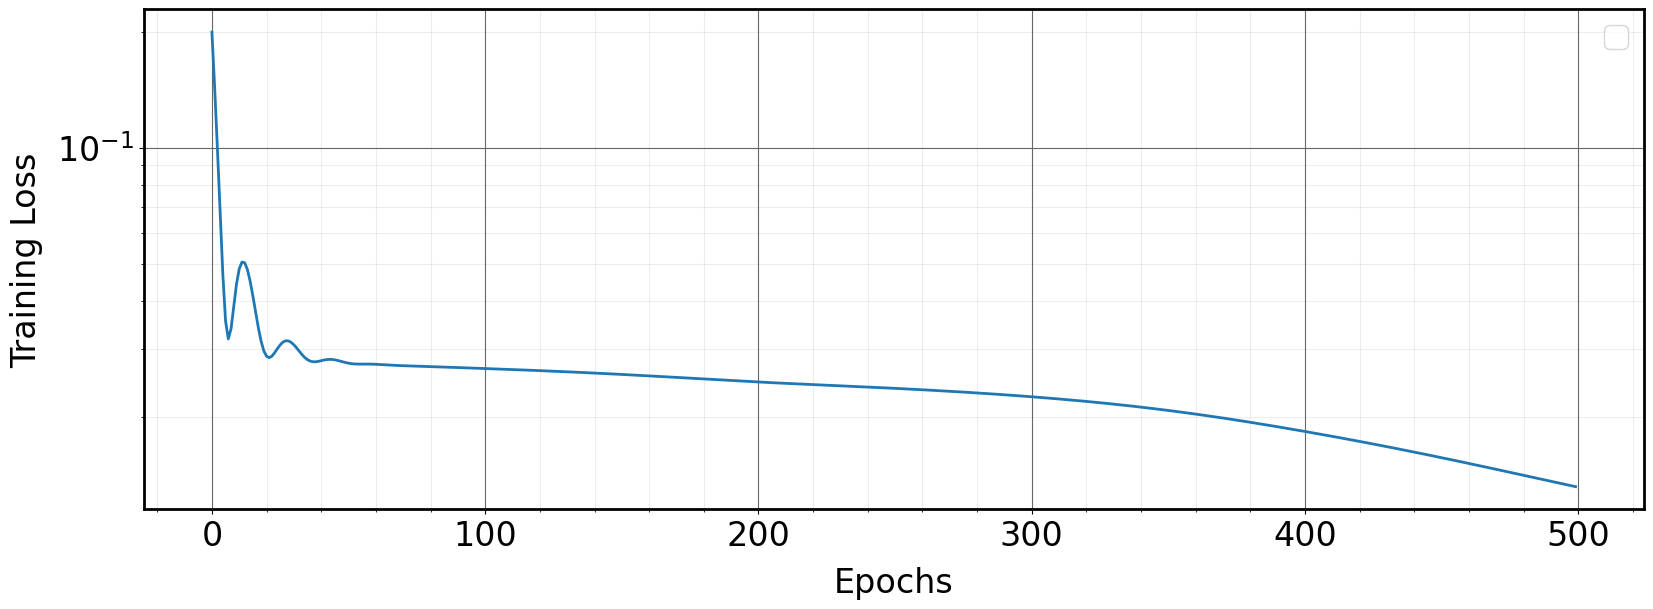

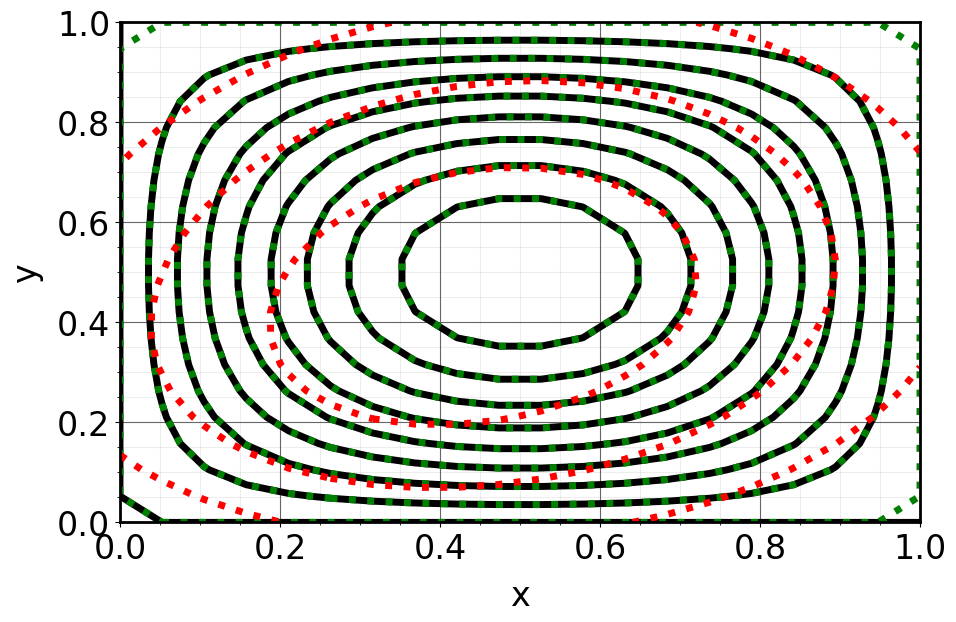

In [6]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
import torch
import torch.nn as nn
from pyDOE import *
from scipy.integrate import odeint
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.__version__
torch.manual_seed(31)
np.random.seed(31)
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x
    def loss_bc_init(self, x, y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u
    def loss_initernal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        u_g = gradients(p, x_train)[0]
        u_x, u_y, u_t = u_g[:, [0]], u_g[:, [1]], u_g[:, [2]]
        u_xx = gradients(u_x, x_train)[0][:, [0]]
        u_yy = gradients(u_y, x_train)[0][:, [1]]
        pde = u_t - D * (u_xx + u_yy)
        loss_pde = pde.pow(2).mean()
        return loss_pde
    def loss(self, x, y, x_to_train_f):
        loss_u = self.loss_bc_init(init_cond_train, u_init_cond_train)
        loss_f = self.loss_initernal(f_train)
        loss_val = loss_u + loss_f
        return loss_val
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)
def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()
def u_2d(x_2d):
    return np.sin(np.pi * x_2d[:, 0]) * np.sin(np.pi * x_2d[:, 1])
def trainingdata(Nx, Ny, Nt, Nf, Nu):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)
    X, Y = np.meshgrid(x, y)
    x_2d = np.concatenate((X.flatten()[:, None], Y.flatten()[:, None]), axis=1)
    t_2d = np.zeros((Nx * Ny, 1))
    intial_condition = np.concatenate((x_2d, t_2d), axis=1)
    u_inital = u_2d(x_2d)[:, None]
    lower_x = np.concatenate((X[:, 0][:, None], Y[:, 0][:, None]), axis=1)
    lower_x = np.tile(lower_x, [int(Nt / Nx), 1])
    lower_x = np.concatenate((lower_x, t[:, None]), axis=1)
    u_lower_x_bc = np.zeros(Nt)[:, None]
    upper_x = np.concatenate((X[:, -1][:, None], Y[:, 0][:, None]), axis=1)
    upper_x = np.tile(upper_x, [int(Nt / Nx), 1])
    upper_x = np.concatenate((upper_x, t[:, None]), axis=1)
    u_upper_x_bc = np.zeros(Nt)[:, None]
    right_y = np.concatenate((X[0, :][:, None], Y[-1, :][:, None]), axis=1)
    right_y = np.tile(right_y, [int(Nt / Nx), 1])
    right_y = np.concatenate((right_y, t[:, None]), axis=1)
    u_right_y_bc = np.zeros(Nt)[:, None]
    left_y = np.concatenate((X[0, :][:, None], Y[0, :][:, None]), axis=1)
    left_y = np.tile(left_y, [int(Nt / Nx), 1])
    left_y = np.concatenate((left_y, t[:, None]), axis=1)
    u_left_y_bc = np.zeros(Nt)[:, None]
    all_Init_bcs = np.vstack([intial_condition, lower_x, upper_x, right_y, left_y])
    all_u_init_bcs = np.vstack([u_inital, u_lower_x_bc, u_upper_x_bc, u_right_y_bc, u_left_y_bc])
    idx = np.random.choice(all_Init_bcs.shape[0], Nu, replace=False)
    all_Init_bcs = all_Init_bcs[idx, :]
    all_u_init_bcs = all_u_init_bcs[idx, :]
    f_train = lhs(3, Nf)
    f_train = np.vstack((f_train, all_Init_bcs))
    return all_Init_bcs, all_u_init_bcs, f_train
def trainingdata(Nx, Ny, Nt, Nf, Nu):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)
    X, Y = np.meshgrid(x, y)
    x_2d = np.concatenate((X.flatten()[:, None], Y.flatten()[:, None]), axis=1)
    t_2d = np.zeros((Nx * Ny, 1))
    intial_condition = np.concatenate((x_2d, t_2d), axis=1)
    u_inital = u_2d(x_2d)[:, None]
    lower_x = np.concatenate((X[:, 0][:, None], Y[:, 0][:, None]), axis=1)
    upper_x = np.concatenate((X[:, -1][:, None], Y[:, 0][:, None]), axis=1)
    right_y = np.concatenate((X[0, :][:, None], Y[-1, :][:, None]), axis=1)
    left_y = np.concatenate((X[0, :][:, None], Y[0, :][:, None]), axis=1)
    x_bound = np.vstack([lower_x, upper_x, right_y, left_y])
    x_bound_ext = np.tile(x_bound, [Nt, 1])
    t_bound_ext = np.tile(t[:, None], [Nx * 4, 1])
    xt_bound_ext = np.concatenate((x_bound_ext, t_bound_ext), axis=1)
    u_bound_ext = np.zeros((Nx * 4 * Nt))[:, None]
    all_Init_bcs = np.vstack([intial_condition, xt_bound_ext])
    all_u_init_bcs = np.vstack([u_inital, u_bound_ext])
    ldx = np.random.permutation(all_Init_bcs.shape[0])
    all_Init_bcs = all_Init_bcs[ldx]
    all_u_init_bcs = all_u_init_bcs[ldx]
    f_train = lhs(3, Nf)
    f_train = np.vstack((f_train, all_Init_bcs))
    return all_Init_bcs, all_u_init_bcs, f_train
N_u = 500
N_x = 30
N_y = 30
N_t = 50
N_f = 10000
init_cond_train_np_array, u_init_cond_train_np_array, f_train_np_array = trainingdata(N_x, N_y, N_t, N_f, N_u)
init_cond_train = nptoTensor(init_cond_train_np_array)
u_init_cond_train = nptoTensor(u_init_cond_train_np_array)
f_train = nptoTensor(f_train_np_array)
D = 0.1
neurons = 50
layers = np.array([3, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, 1])
mlp = MLP(layers).to(device)
step_size = 10000
gamma = 0.1
A_hist = []
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
max_iter = 500
tic = time.time()
for i in range(max_iter):
    loss = mlp.loss(init_cond_train, u_init_cond_train, f_train)
    A_hist.append([i, loss.detach().cpu().item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i + 1) % 100 == 0:
        print("Epoch: {}, MSE: {:.6f}".format((i + 1), loss.detach().cpu().item()))
toc = time.time()
print(f'total training time in minutes: {(toc - tic) / 60}')
A_hist = np.array(A_hist)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(visible=True, which='major', color='#666666', linestyle='-')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
ax.plot(A_hist[:, 0], A_hist[:, 1], linewidth=2, label='')
ax.legend(loc='best', frameon=True, fontsize=22)
ax.semilogy()
ax.set_xlabel('Epochs', labelpad=10)
ax.set_ylabel('Training Loss', labelpad=10)
path = '2-Diffusion_PDE4.pth'
torch.save(mlp.state_dict(), path)
path = '/content/2-Diffusion_PDE4.pth'
mlp.load_state_dict(torch.load(path))
mlp.eval()
model = MLP(layers)
state_dict = torch.load(path)
model.load_state_dict(state_dict)
model.eval()
example = torch.rand([1, 3])
traced_script_module = torch.jit.trace(model, example)
torch.jit.save(traced_script_module, "2D-Diffusion_PDE.pt")
loaded = torch.jit.load("2D-Diffusion_PDE.pt")
def build_mesh(N, t):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t])
    m = np.meshgrid(x, y, _t)
    m = np.stack(m, -1).reshape(-1, 3)
    return x, y, m
def build_mesh1(N, t):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t])
    x, y, t = np.meshgrid(x, y, _t)
    return x, y, t
n = 20
t = 0
def central_difference():
    return u[n][i][j] + delta_t * (alpha * (u[n][i+1][j] + u[n][i-1][j] + u[n][i][j+1] + u[n][i][j-1] - 4 * u[n][i][j]) / (delta_x)**2)
def initial(x, y):
    x = x[1:-1]
    y = y[1:-1]
    x, y = np.meshgrid(x, y)
    return np.sin(np.pi * x) * np.sin(np.pi * y)
points_in_x = 20
points_in_y = 20
alpha = 0.1
x = np.linspace(0, 1, points_in_x)
delta_x = x[1] - x[0]
y = np.linspace(0, 1, points_in_x)
delta_y = y[1] - y[0]
delta_t = 0.5 * (delta_x**2 * delta_y**2) / ((delta_x**2 + delta_y**2) * alpha)
points_in_t = int(1. / delta_t)
t = np.linspace(0, 1, points_in_t)
u = np.zeros((len(t), len(x), len(y)))
u[:, 0, :] = 0
u[:, len(x) - 1, :] = 0
u[:, :, 0] = 0
u[:, :, len(y) - 1] = 0
u[0, 1:len(x) - 1, 1:len(y) - 1] = initial(x, y)
for n in range(0, len(t) - 1):
    for i in range(1, len(x) - 1):
        for j in range(1, len(y) - 1):
            u[n + 1][i][j] = central_difference()
n = 20
def build_mesh(N, t):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t])
    m = np.meshgrid(x, y, _t)
    m = np.stack(m, -1).reshape(-1, 3)
    return x, y, m
def build_mesh1(N, t):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t])
    x, y, t = np.meshgrid(x, y, _t)
    return x, y, t
x1, y1, m1 = build_mesh(n, 0)
x2, y2, m2 = build_mesh(n, 0.25)
x3, y3, m3 = build_mesh(n, 0.5)
x4, y4, m4 = build_mesh(n, 0.75)
x5, y5, m5 = build_mesh(n, 1)
xe1, ye1, te1 = build_mesh1(n, 0)
xe2, ye2, te2 = build_mesh1(n, 0.25)
xe3, ye3, te3 = build_mesh1(n, 0.5)
xe4, ye4, te4 = build_mesh1(n, 0.75)
xe5, ye5, te5 = build_mesh1(n, 1)
def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return np.abs(p)
p1 = eval_model(m1)
p2 = eval_model(m2)
p3 = eval_model(m3)
p4 = eval_model(m4)
p5 = eval_model(m5)
def plot_model(x, y, p, x1, y1, t, u_fdm):
    pe = np.sin(np.pi * y1) * np.sin(np.pi * x1) * np.exp((-.1 * t) * (2 * np.pi**2))
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    img1 = ax.contour(x, y, pe.reshape(-1, n), linewidths=5, levels=np.linspace(0, 1, 10), colors='k', linestyles='solid')
    img2 = ax.contour(x, y, u_fdm.reshape(-1, n), linewidths=5, levels=np.linspace(0, 1, 10), colors='green', linestyles='dotted')
    img3 = ax.contour(x, y, p.reshape(-1, n), linewidths=5, levels=np.linspace(0, 1, 10), colors='red', linestyles='dotted')
    ax.grid(visible=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(visible=True, which='minor', color='#555555', linestyle='-', alpha=0.1)
    ax.set_xlabel('x', labelpad=10)
    ax.set_ylabel('y', labelpad=10)
plot_model(x1, y1, p1, xe1, ye1, te1, u[0, :])


cuda
2.5.1+cu124
Epoch 100: Loss 0.0000
Epoch 200: Loss 0.0000
Epoch 300: Loss 0.0000
Epoch 400: Loss 0.0000
Epoch 500: Loss 0.0000


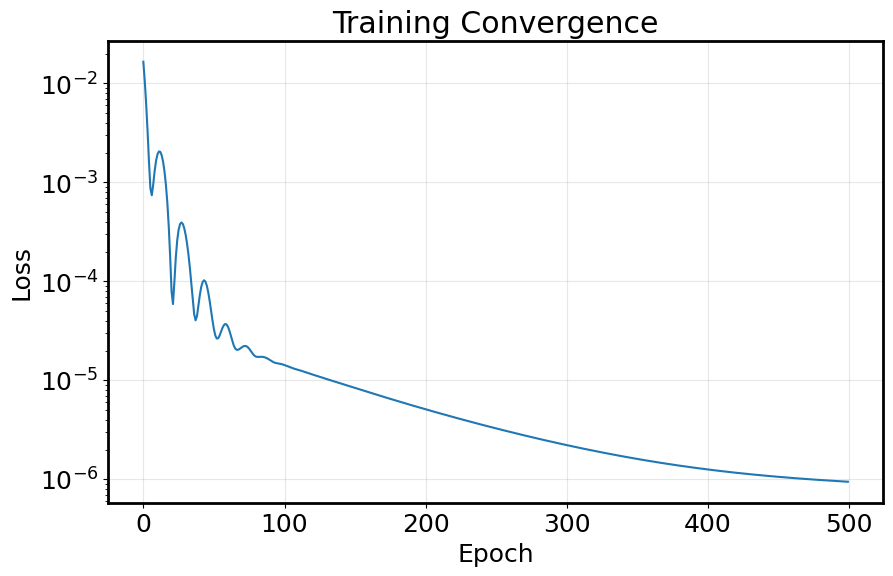

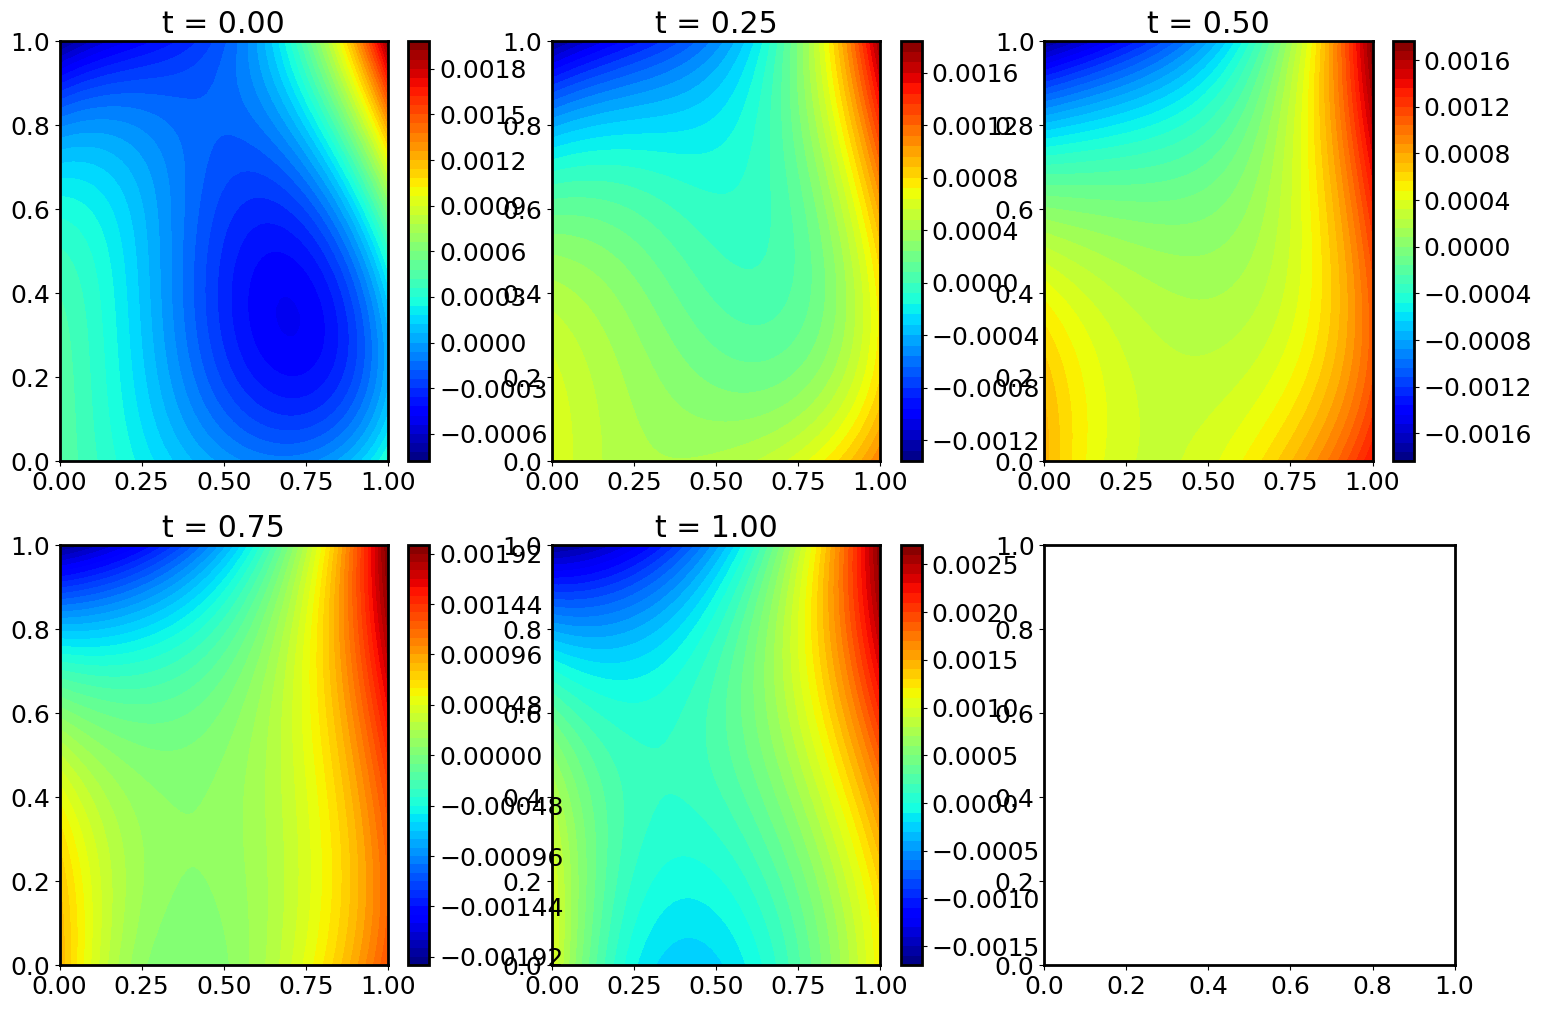

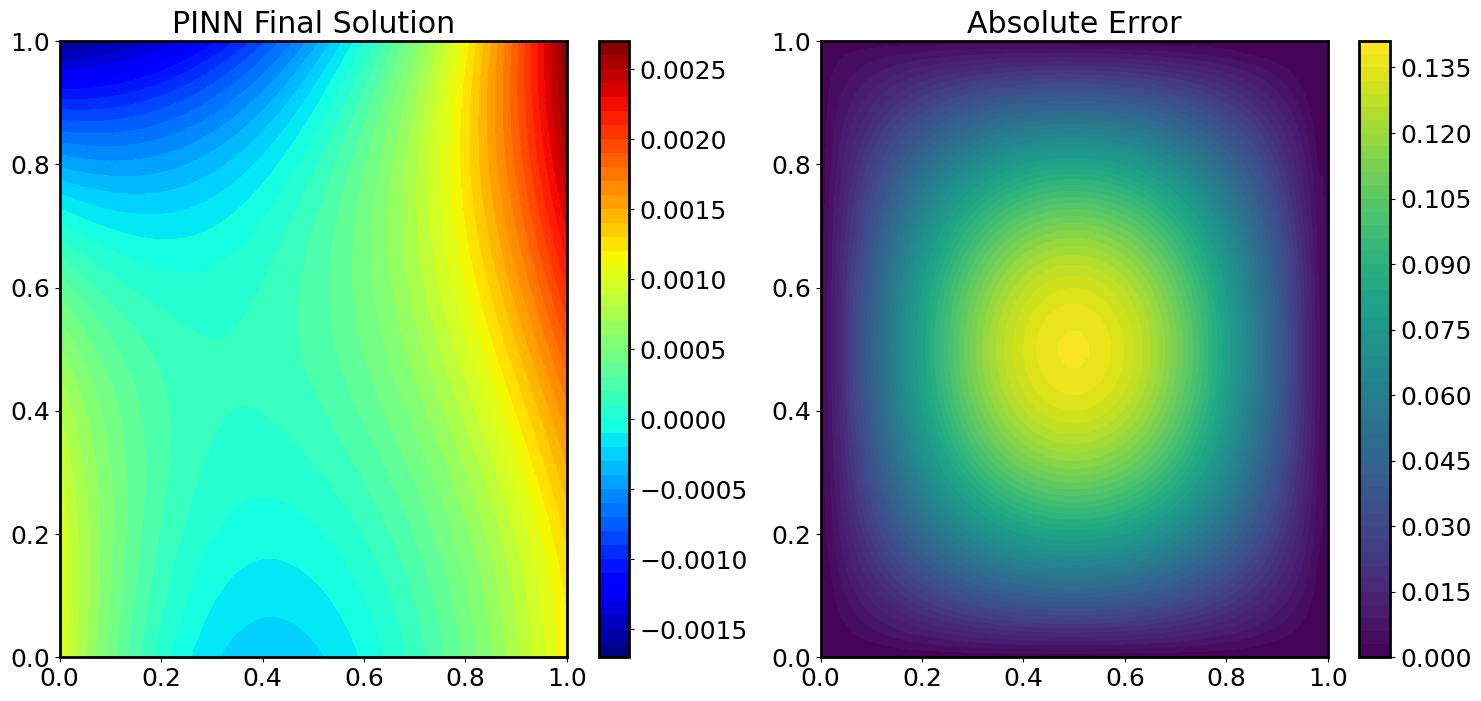

In [8]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pyDOE import lhs
import time
import scipy.special as sp

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.__version__)
torch.manual_seed(31)
np.random.seed(31)

# Neural Network (Unchanged from original)
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x

    def loss_bc(self, x_bc, y_bc):
        return self.loss_function(self.forward(x_bc), y_bc)

    def loss_pde(self, x_colloc):
        x_colloc.requires_grad = True
        u = self.forward(x_colloc)
        u_t = gradients(u, x_colloc)[0][:, [2]]  # Time derivative
        u_x = gradients(u, x_colloc)[0][:, [0]]  # Spatial derivatives
        u_y = gradients(u, x_colloc)[0][:, [1]]
        u_xx = gradients(u_x, x_colloc)[0][:, [0]]
        u_yy = gradients(u_y, x_colloc)[0][:, [1]]
        return torch.mean((u_t - D*(u_xx + u_yy))**2)

# Fixed Data Preparation
def training_data(Nx, Ny, Nt, Nf, Nu):
    # Spatial grid (x,y)
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    X, Y = np.meshgrid(x, y)

    # Boundary conditions with time=0
    x_bc = np.hstack((X.flatten()[:, None],
                     Y.flatten()[:, None],
                     np.zeros((Nx*Ny, 1))))  # Add temporal dimension t=0

    # Collocation points (x,y,t)
    x_colloc = lhs(3, Nf)  # Already contains x,y,t

    return x_bc, x_colloc

# Configuration
D = 0.1
layers = [3, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 1]  # First layer expects 3 inputs (x,y,t)
model = MLP(layers).to(device)

# Training Setup
Nu = 500
Nf = 10000
x_bc, x_colloc = training_data(30, 30, 50, Nf, Nu)  # Now x_bc has shape (900, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_history = []

# Training Loop
for epoch in range(500):
    optimizer.zero_grad()

    # Convert inputs with correct dimensions
    bc_tensor = nptoTensor(x_bc)  # Now (900,3)
    colloc_tensor = nptoTensor(x_colloc)  # (Nf,3)

    loss = model.loss_bc(bc_tensor, torch.zeros_like(bc_tensor[:, [0]])) + \
           model.loss_pde(colloc_tensor)

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}: Loss {loss.item():.4f}")


# Enhanced Visualization (Added from paste2.txt)
def plot_convergence(history):
    plt.figure(figsize=(10,6))
    plt.semilogy(history)
    plt.title('Training Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.savefig('convergence_2d.png', dpi=300)

def plot_solution_snapshots():
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    times = [0, 0.25, 0.5, 0.75, 1.0]

    for idx, t in enumerate(times):
        x = np.linspace(0, 1, 50)
        y = np.linspace(0, 1, 50)
        X, Y = np.meshgrid(x, y)
        inputs = np.hstack((X.flatten()[:,None],
                          Y.flatten()[:,None],
                          np.full_like(X.flatten()[:,None], t)))
        with torch.no_grad():
            pred = model(nptoTensor(inputs)).cpu().numpy()

        ax = axs[idx//3, idx%3]
        cont = ax.contourf(X, Y, pred.reshape(X.shape), levels=50, cmap='jet')
        plt.colorbar(cont, ax=ax)
        ax.set_title(f't = {t:.2f}')

    plt.savefig('solution_snapshots_2d.png', dpi=300)

def plot_error_analysis():
    x = np.linspace(0, 1, 50)
    y = np.linspace(0, 1, 50)
    X, Y = np.meshgrid(x, y)

    # PINN Prediction
    inputs = np.hstack((X.flatten()[:,None],
                       Y.flatten()[:,None],
                       np.ones_like(X.flatten()[:,None])))
    with torch.no_grad():
        pinn_pred = model(nptoTensor(inputs)).cpu().numpy()

    # Analytical Solution
    analytic = np.sin(np.pi*X) * np.sin(np.pi*Y) * np.exp(-2*D*np.pi**2)

    # Error calculation
    error = np.abs(pinn_pred.reshape(X.shape) - analytic)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    cont0 = axs[0].contourf(X, Y, pinn_pred.reshape(X.shape), levels=50, cmap='jet')
    cont1 = axs[1].contourf(X, Y, error, levels=50, cmap='viridis')

    plt.colorbar(cont0, ax=axs[0])
    plt.colorbar(cont1, ax=axs[1])
    axs[0].set_title('PINN Final Solution')
    axs[1].set_title('Absolute Error')
    plt.savefig('error_analysis_2d.png', dpi=300)

# Execute visualizations
plot_convergence(loss_history)
plot_solution_snapshots()
plot_error_analysis()

# Model saving (Added from paste2.txt)
torch.save(model.state_dict(), '2d_diffusion_model.pth')


cuda
Epoch: 100, MSE: 0.026761
Epoch: 200, MSE: 0.024696
Epoch: 300, MSE: 0.022623
Epoch: 400, MSE: 0.018416
Epoch: 500, MSE: 0.013206
Total training time: 0.39 minutes


TypeError: list indices must be integers or slices, not tuple

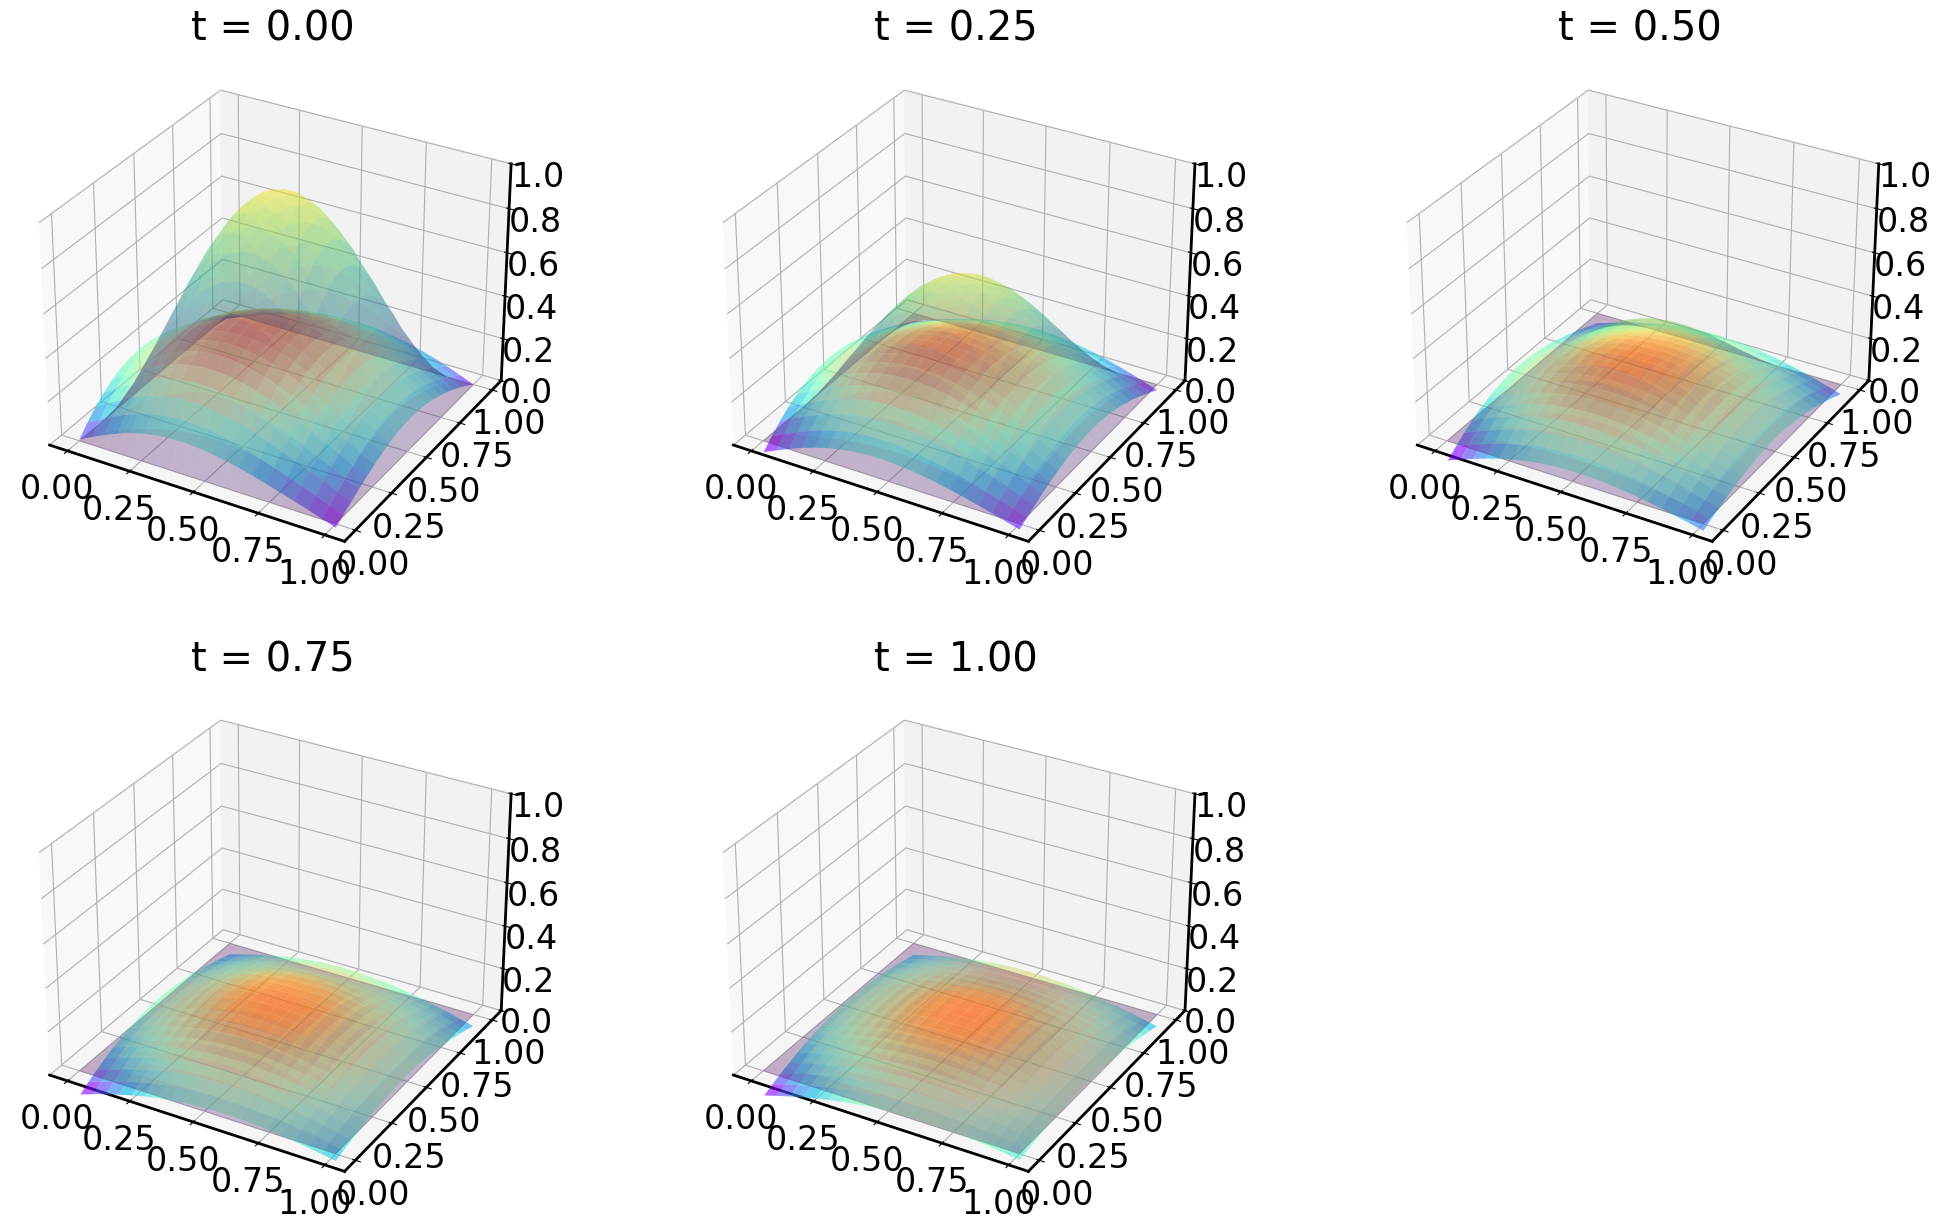

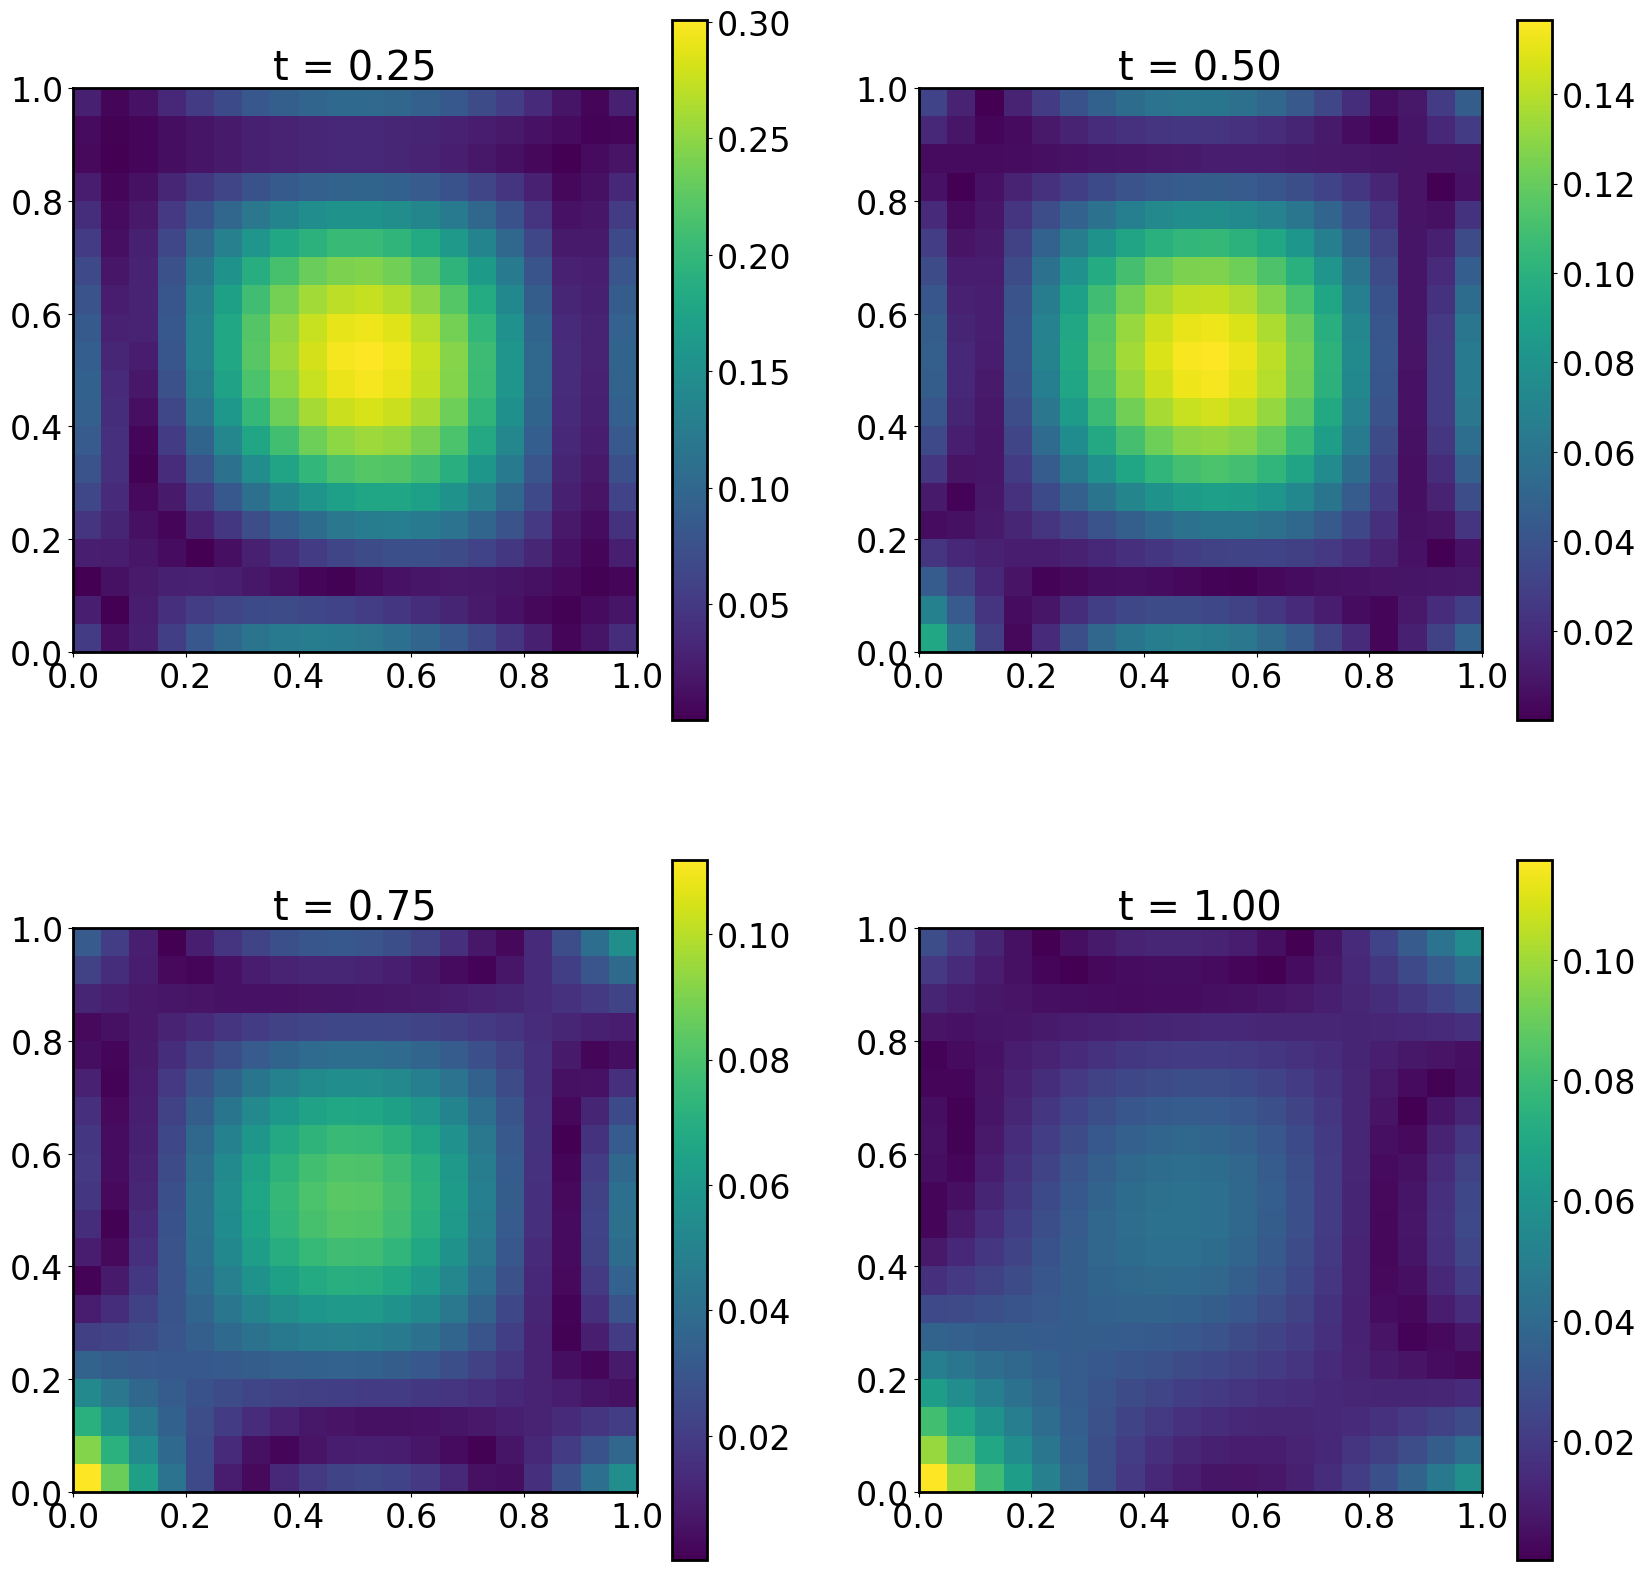

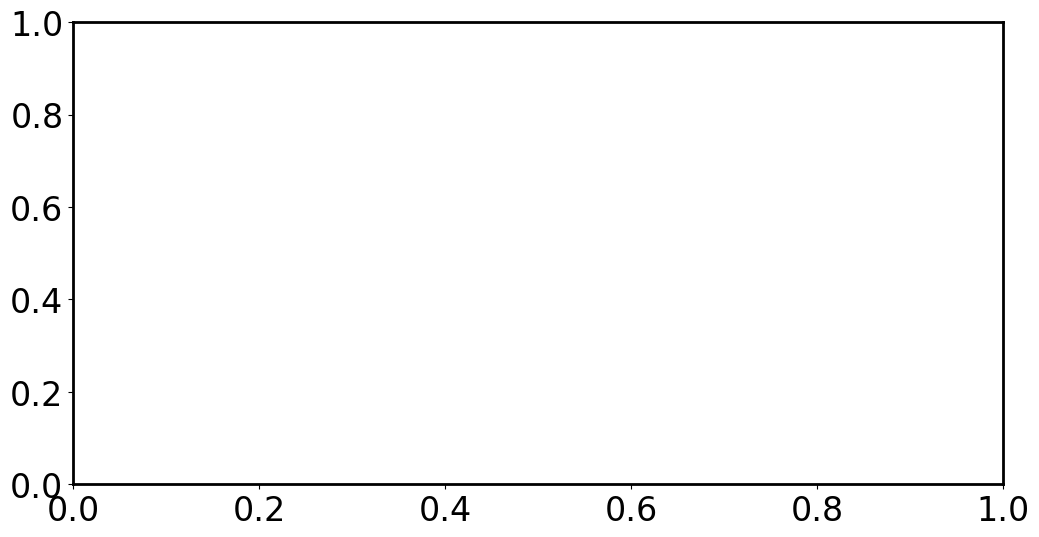

In [9]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
import torch
import torch.nn as nn
from pyDOE import *
import time
import scipy.special as sp
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(31)
np.random.seed(31)

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x

    def loss_bc_init(self, x, y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u

    def loss_initernal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        u_g = torch.autograd.grad(p, x_train, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        u_x, u_y, u_t = u_g[:, [0]], u_g[:, [1]], u_g[:, [2]]
        u_xx = torch.autograd.grad(u_x, x_train, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, [0]]
        u_yy = torch.autograd.grad(u_y, x_train, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, [1]]
        pde = u_t - D * (u_xx + u_yy)
        loss_pde = pde.pow(2).mean()
        return loss_pde

    def loss(self, x, y, x_to_train_f):
        loss_u = self.loss_bc_init(x, y)
        loss_f = self.loss_initernal(x_to_train_f)
        return loss_u + loss_f

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

def u_2d(x_2d):
    return np.sin(np.pi * x_2d[:, 0]) * np.sin(np.pi * x_2d[:, 1])

def trainingdata(Nx, Ny, Nt, Nf, Nu):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)
    X, Y = np.meshgrid(x, y)
    x_2d = np.concatenate((X.flatten()[:, None], Y.flatten()[:, None]), axis=1)
    t_2d = np.zeros((Nx * Ny, 1))
    intial_condition = np.concatenate((x_2d, t_2d), axis=1)
    u_inital = u_2d(x_2d)[:, None]
    lower_x = np.concatenate((X[:, 0][:, None], Y[:, 0][:, None]), axis=1)
    upper_x = np.concatenate((X[:, -1][:, None], Y[:, 0][:, None]), axis=1)
    right_y = np.concatenate((X[0, :][:, None], Y[-1, :][:, None]), axis=1)
    left_y = np.concatenate((X[0, :][:, None], Y[0, :][:, None]), axis=1)
    x_bound = np.vstack([lower_x, upper_x, right_y, left_y])
    x_bound_ext = np.tile(x_bound, [Nt, 1])
    t_bound_ext = np.tile(t[:, None], [Nx * 4, 1])
    xt_bound_ext = np.concatenate((x_bound_ext, t_bound_ext), axis=1)
    u_bound_ext = np.zeros((Nx * 4 * Nt))[:, None]
    all_Init_bcs = np.vstack([intial_condition, xt_bound_ext])
    all_u_init_bcs = np.vstack([u_inital, u_bound_ext])
    ldx = np.random.permutation(all_Init_bcs.shape[0])
    all_Init_bcs = all_Init_bcs[ldx]
    all_u_init_bcs = all_u_init_bcs[ldx]
    f_train = lhs(3, Nf)
    f_train = np.vstack((f_train, all_Init_bcs))
    return all_Init_bcs, all_u_init_bcs, f_train

N_u = 500
N_x = 30
N_y = 30
N_t = 50
N_f = 10000
D = 0.1
init_cond_train_np_array, u_init_cond_train_np_array, f_train_np_array = trainingdata(N_x, N_y, N_t, N_f, N_u)
init_cond_train = nptoTensor(init_cond_train_np_array)
u_init_cond_train = nptoTensor(u_init_cond_train_np_array)
f_train = nptoTensor(f_train_np_array)

neurons = 50
layers = np.array([3, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, 1])
mlp = MLP(layers).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
A_hist = []
max_iter = 500
tic = time.time()

for i in range(max_iter):
    loss = mlp.loss(init_cond_train, u_init_cond_train, f_train)
    A_hist.append([i, loss.detach().cpu().item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i + 1) % 100 == 0:
        print(f"Epoch: {i+1}, MSE: {loss.detach().cpu().item():.6f}")

toc = time.time()
print(f'Total training time: {(toc - tic)/60:.2f} minutes')

def build_mesh(N, t_val):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t_val])
    m = np.meshgrid(x, y, _t)
    m = np.stack(m, -1).reshape(-1, 3)
    return x, y, m

def analytical_solution(x, y, t, D):
    return np.sin(np.pi*x) * np.sin(np.pi*y) * np.exp(-2*(np.pi**2)*D*t)

points_in_x = 20
points_in_y = 20
alpha = 0.1
x_fdm = np.linspace(0, 1, points_in_x)
y_fdm = np.linspace(0, 1, points_in_y)
delta_x = x_fdm[1] - x_fdm[0]
delta_y = y_fdm[1] - y_fdm[0]
delta_t = 0.5 * (delta_x**2 * delta_y**2) / ((delta_x**2 + delta_y**2) * alpha)
points_in_t = int(1. / delta_t)
t_fdm = np.linspace(0, 1, points_in_t)
u = np.zeros((len(t_fdm), len(x_fdm), len(y_fdm)))

def initial(x, y):
    return np.sin(np.pi*x) * np.sin(np.pi*y)

u[0, 1:-1, 1:-1] = initial(x_fdm[1:-1], y_fdm[1:-1])

for n in range(len(t_fdm)-1):
    for i in range(1, len(x_fdm)-1):
        for j in range(1, len(y_fdm)-1):
            u[n+1,i,j] = u[n,i,j] + delta_t*alpha*(
                (u[n,i+1,j] - 2*u[n,i,j] + u[n,i-1,j])/delta_x**2 +
                (u[n,i,j+1] - 2*u[n,i,j] + u[n,i,j-1])/delta_y**2)

def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

def plot_3d_surfaces():
    times = [0, 0.25, 0.5, 0.75, 1]
    fig = plt.figure(figsize=(25, 15))
    for idx, t_val in enumerate(times):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        x = np.linspace(0, 1, 20)
        y = np.linspace(0, 1, 20)
        X, Y = np.meshgrid(x, y)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])
        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))
        fdm = u[fdm_idx,:,:]

        ax.plot_surface(X, Y, pinn, cmap='rainbow', alpha=0.6)
        ax.plot_surface(X, Y, analytic, cmap='viridis', alpha=0.3)
        ax.set_title(f't = {t_val:.2f}')
        ax.set_zlim(0,1)
    plt.savefig('3D_Surface_Comparison.png', dpi=300)

def plot_error_snapshots():
    times = [0.25, 0.5, 0.75, 1]
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    for idx, t_val in enumerate(times):
        ax = axs[idx//2, idx%2]
        x, y, m = build_mesh(20, t_val)
        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(m[:,0], m[:,1], t_val, D).reshape(20,20)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))
        fdm = u[fdm_idx,:,:]

        err = np.abs(pinn - analytic)
        im = ax.imshow(err.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=ax)
        ax.set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Snapshots.png', dpi=300)

def plot_convergence_metrics():
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.semilogy(A_hist[:,0], A_hist[:,1], 'b-')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (log scale)', color='b')
    plt.savefig('Convergence.png', dpi=300)

def plot_error_heatmaps():
    fig, axs = plt.subplots(1, 3, figsize=(30,8))
    t_vals = [0.25, 0.5, 1.0]
    for idx, t_val in enumerate(t_vals):
        x, y, m = build_mesh(20, t_val)
        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(m[:,0], m[:,1], t_val, D).reshape(20,20)
        err = np.abs(pinn - analytic)
        im = axs[idx].imshow(err.T, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=0.1),
                          origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=axs[idx])
        axs[idx].set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Heatmaps.png', dpi=300)

def plot_temporal_evolution():
    points = [(0.25,0.25), (0.5,0.5), (0.75,0.75)]
    fig, axs = plt.subplots(3, 1, figsize=(10,15))
    for idx, (x_val, y_val) in enumerate(points):
        t_vals = np.linspace(0, 1, 50)
        pinn_t = []
        analytic_t = []
        fdm_t = []

        for ti in t_vals:
            m = np.array([[x_val, y_val, ti]])
            pinn_t.append(eval_model(m)[0])
            analytic_t.append(analytical_solution(x_val, y_val, ti, D))
            fdm_idx_t = int(np.round(ti * (len(t_fdm)-1)))
            fdm_idx_x = np.argmin(np.abs(x_fdm - x_val))
            fdm_idx_y = np.argmin(np.abs(y_fdm - y_val))
            fdm_t.append(u[fdm_idx_t, fdm_idx_x, fdm_idx_y])

        axs[idx].plot(t_vals, analytic_t, 'b-', label='Analytical')
        axs[idx].plot(t_vals, pinn_t, 'r--', label='PINN')
        axs[idx].plot(t_vals, fdm_t, 'g:', label='FDM')
        axs[idx].set_title(f'(x,y) = ({x_val:.2f},{y_val:.2f})')
        axs[idx].grid(True)
    plt.savefig('Temporal_Evolution.png', dpi=300)

plot_3d_surfaces()
plot_error_snapshots()
plot_convergence_metrics()
plot_error_heatmaps()
plot_temporal_evolution()

cuda
Epoch: 100, MSE: 0.026761
Epoch: 200, MSE: 0.024696
Epoch: 300, MSE: 0.022623
Epoch: 400, MSE: 0.018416
Epoch: 500, MSE: 0.013206
Total training time: 0.38 minutes


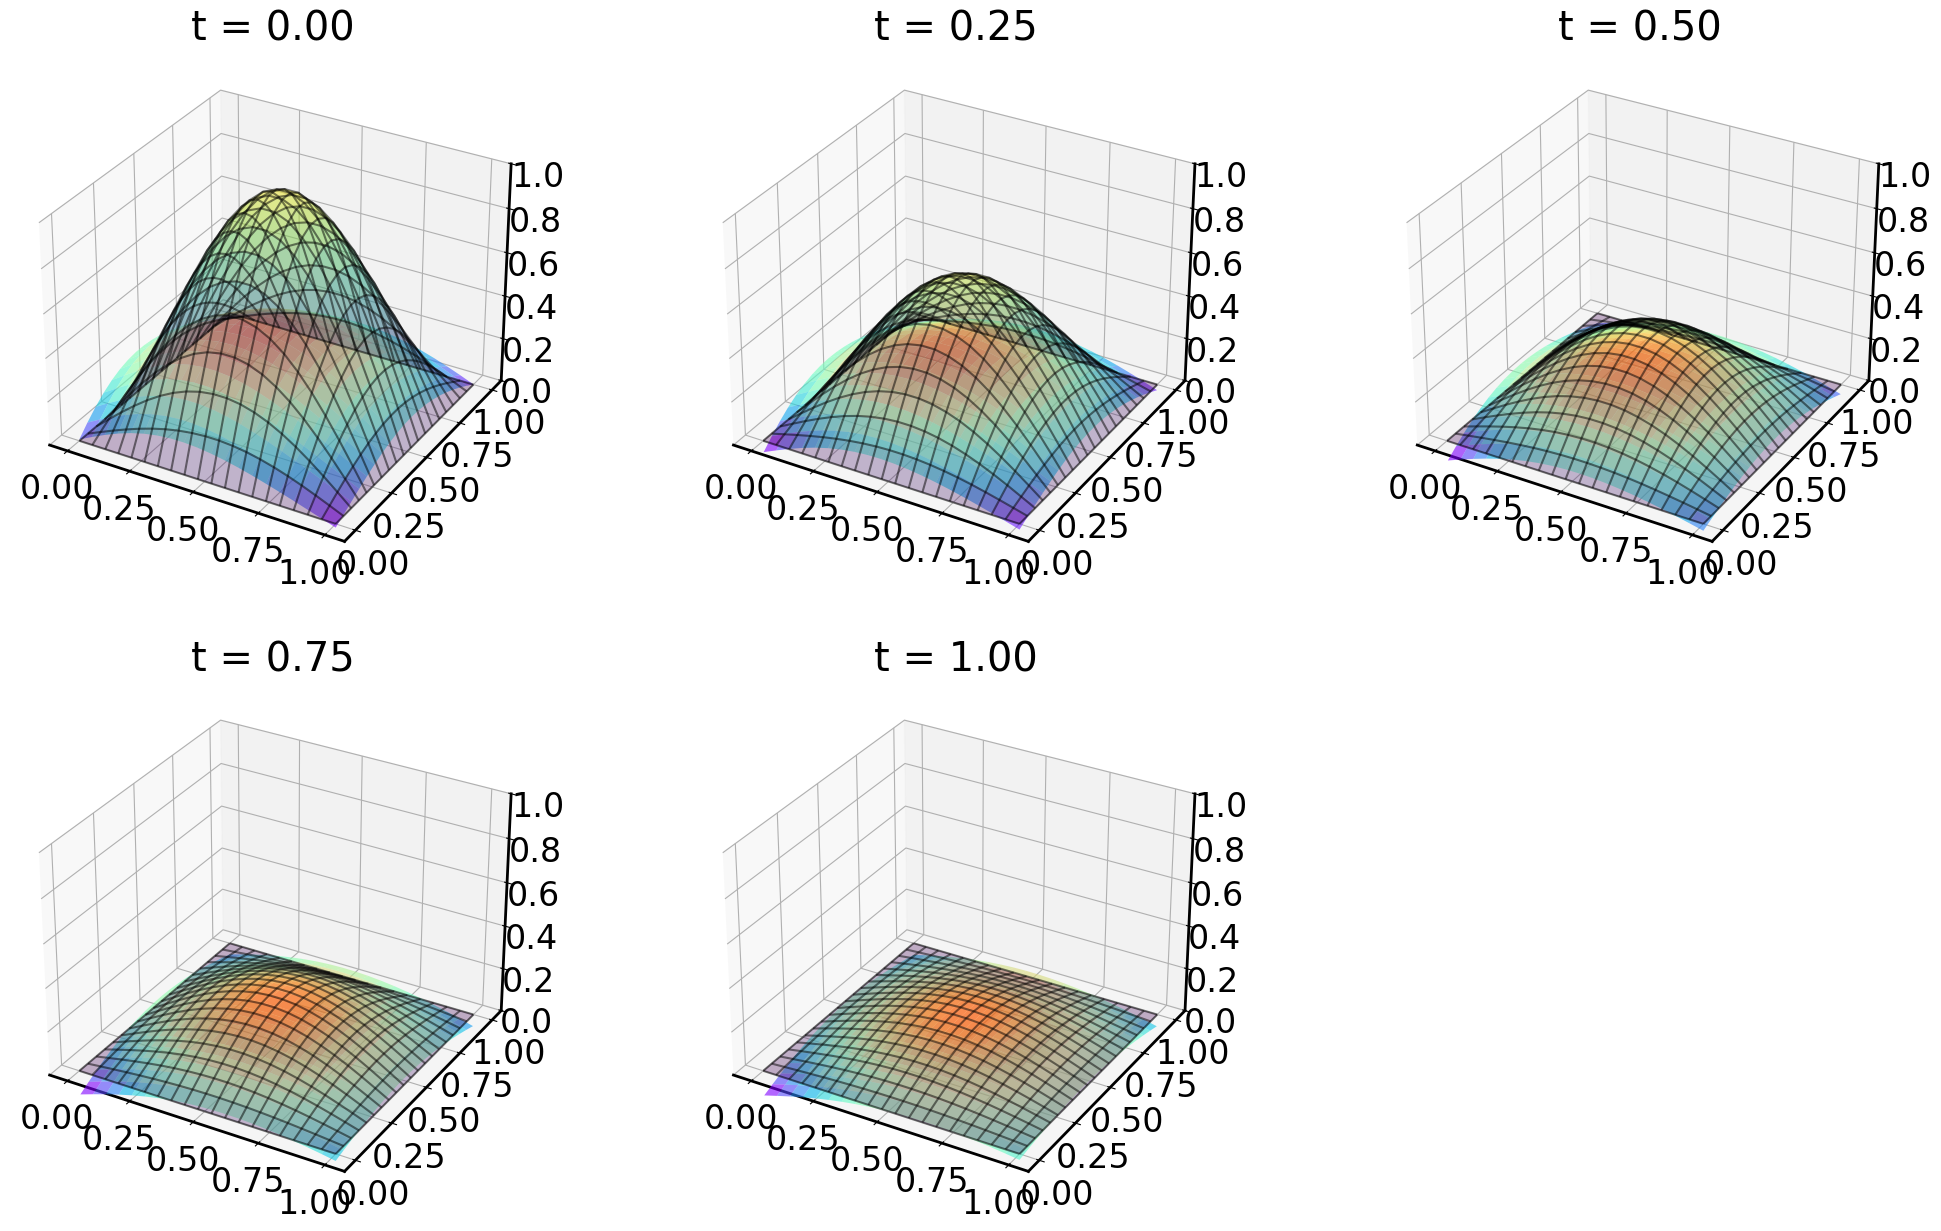

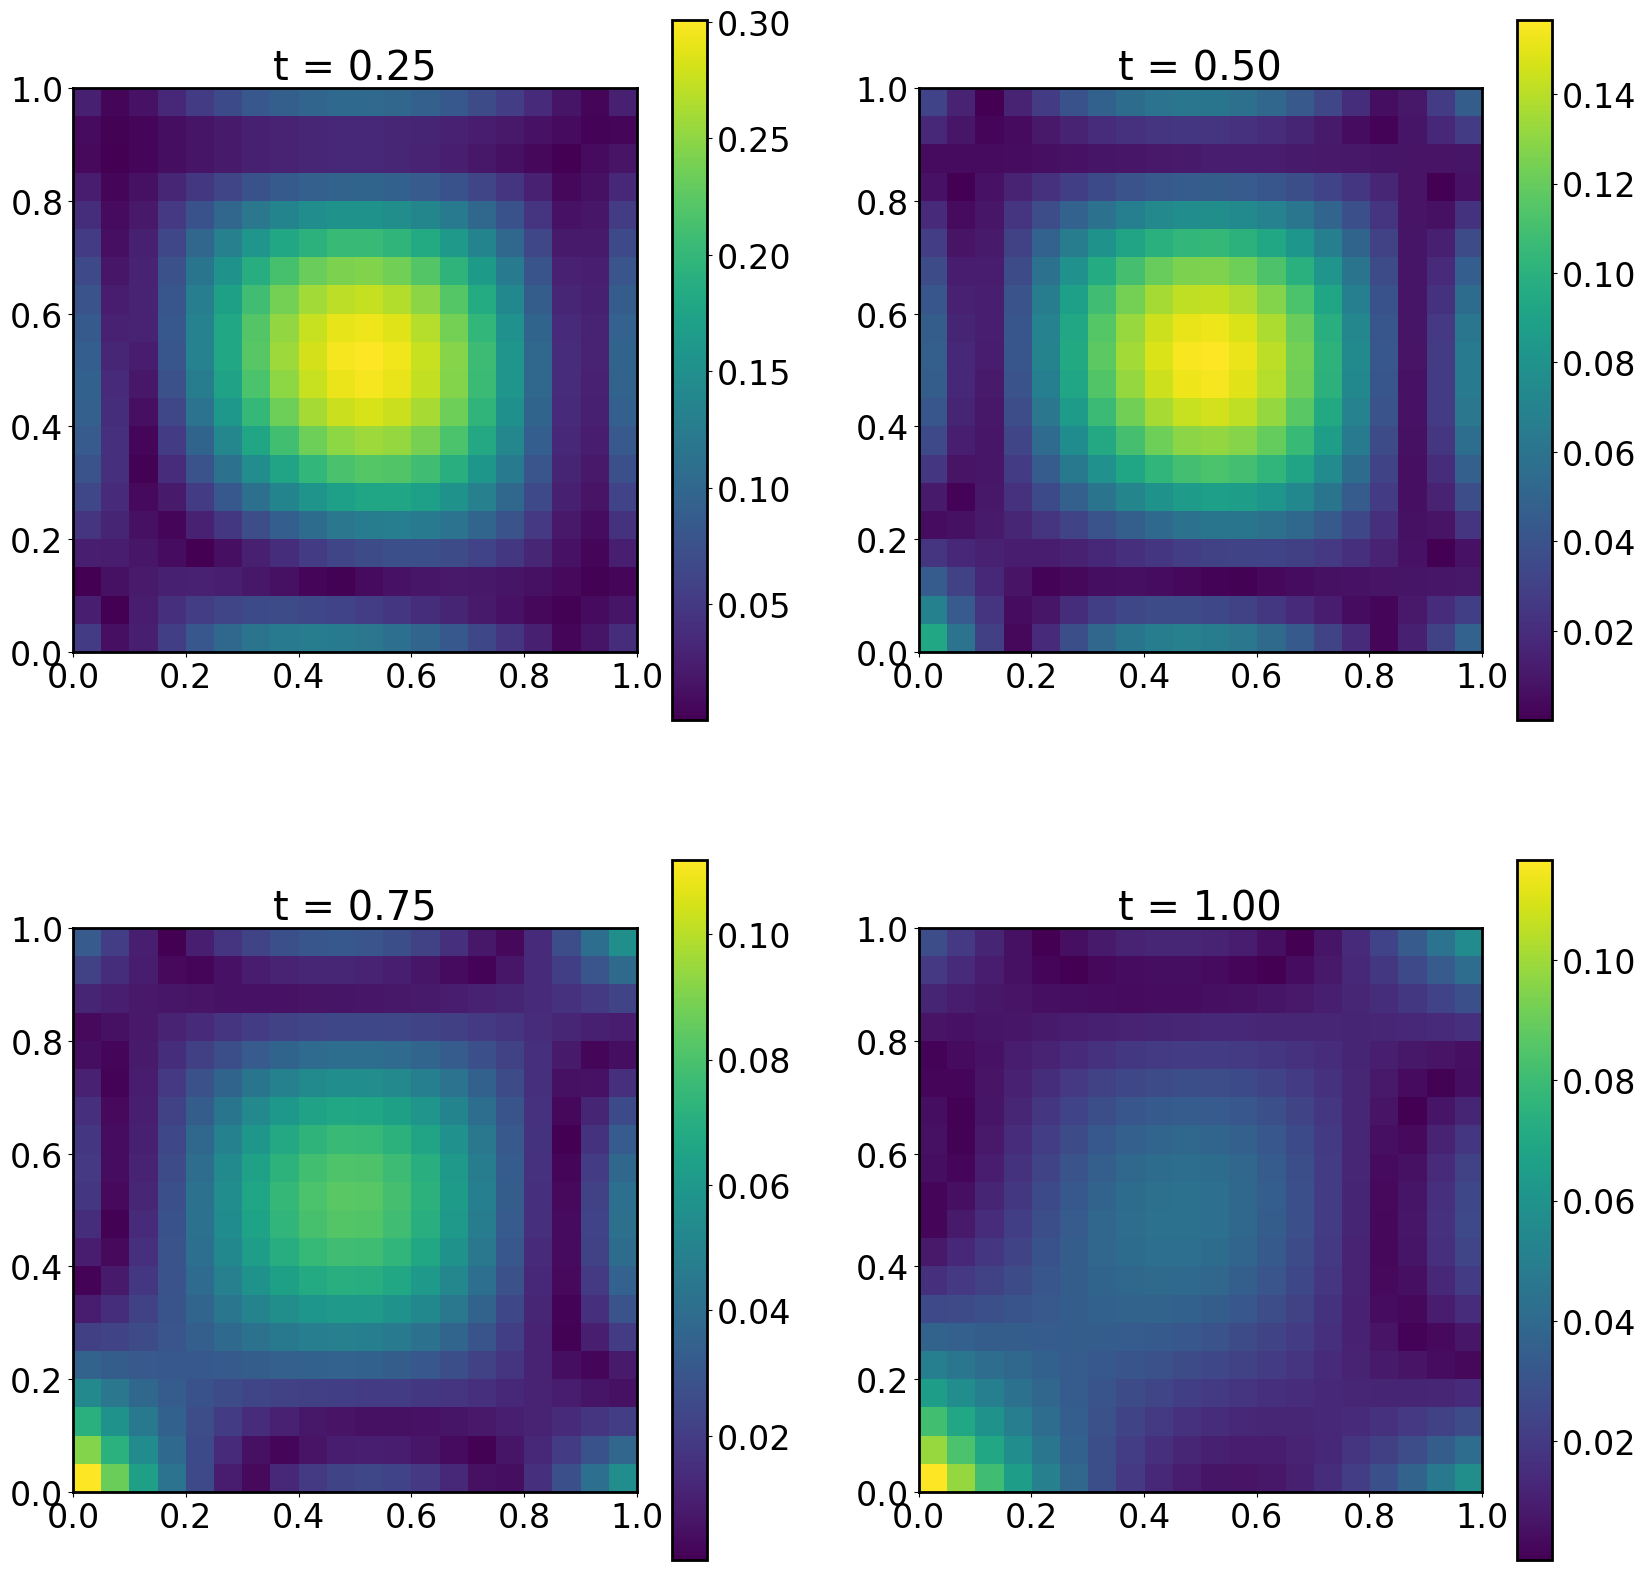

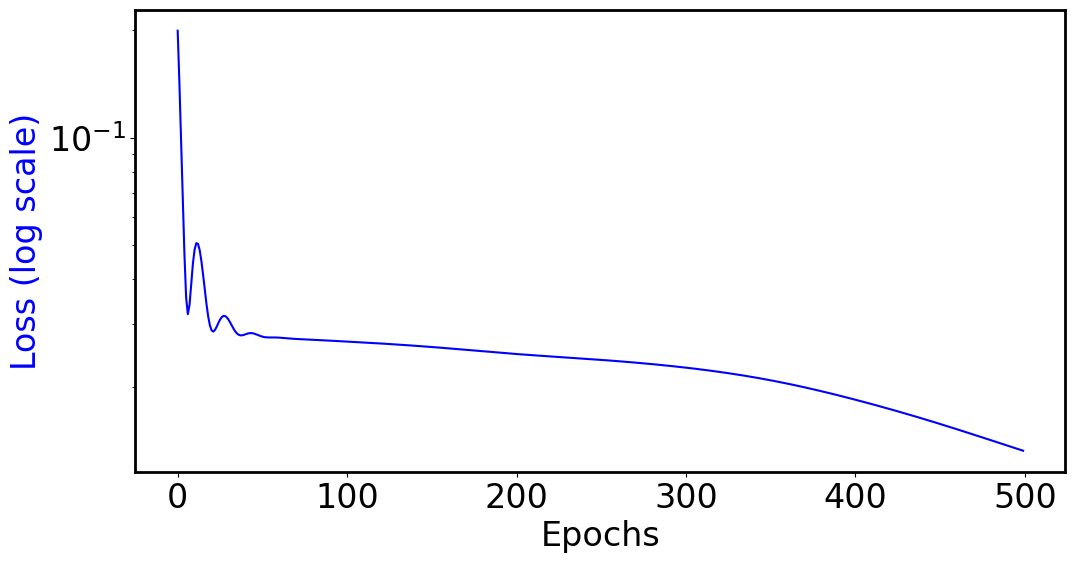

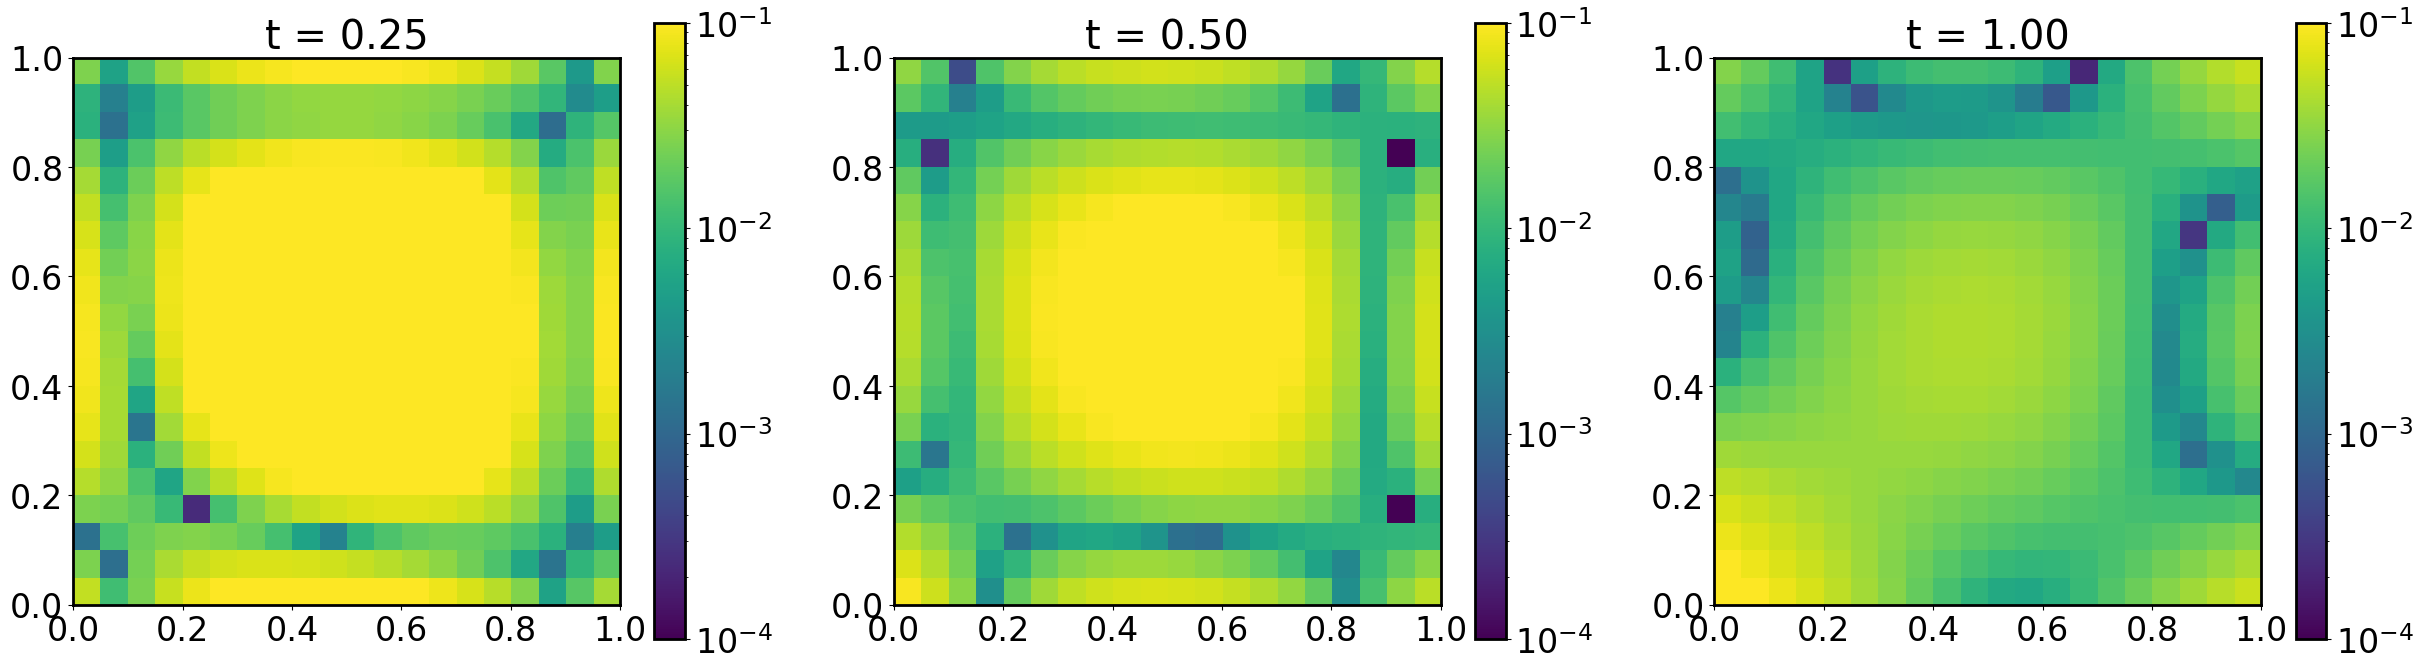

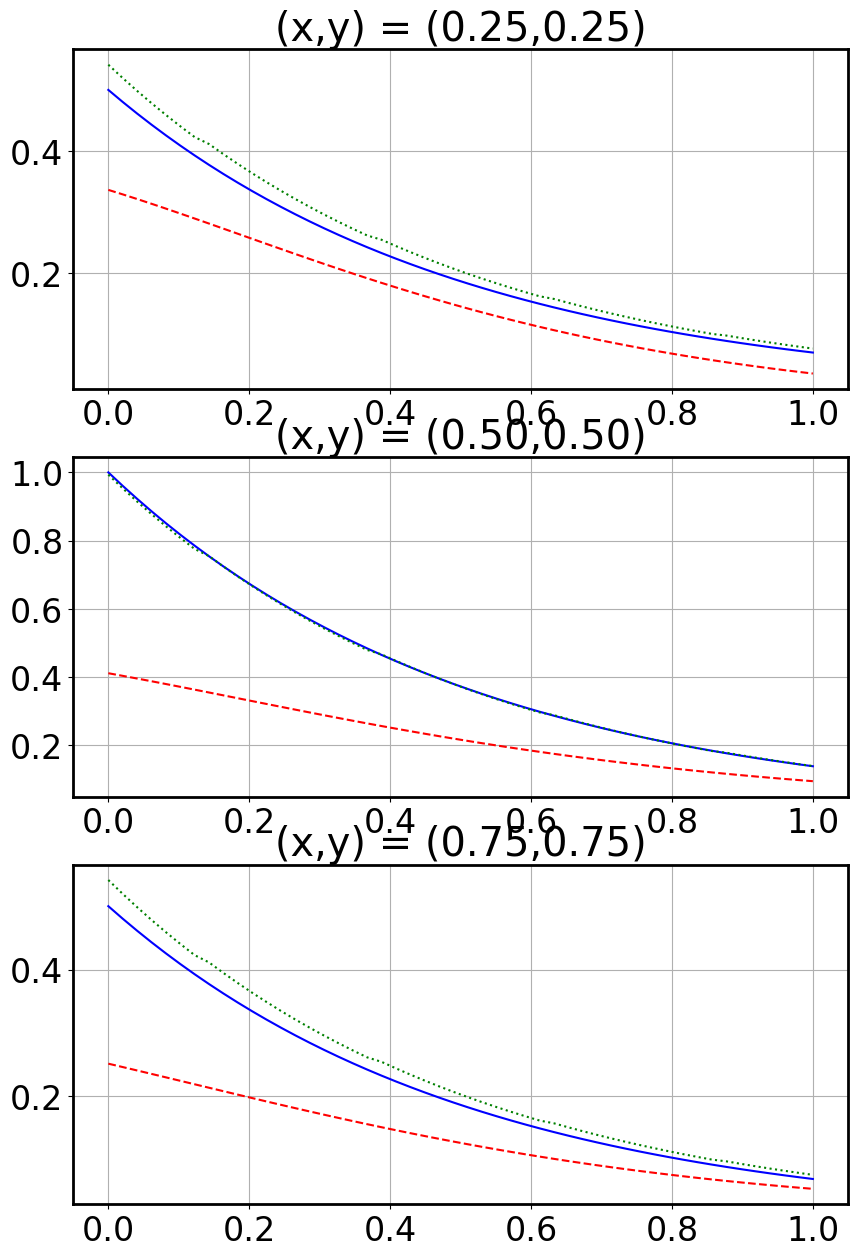

In [10]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
import torch
import torch.nn as nn
from pyDOE import *
import time
import scipy.special as sp
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(31)
np.random.seed(31)

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x

    def loss_bc_init(self, x, y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u

    def loss_initernal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        u_g = torch.autograd.grad(p, x_train, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        u_x, u_y, u_t = u_g[:, [0]], u_g[:, [1]], u_g[:, [2]]
        u_xx = torch.autograd.grad(u_x, x_train, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, [0]]
        u_yy = torch.autograd.grad(u_y, x_train, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, [1]]
        pde = u_t - D * (u_xx + u_yy)
        loss_pde = pde.pow(2).mean()
        return loss_pde

    def loss(self, x, y, x_to_train_f):
        loss_u = self.loss_bc_init(x, y)
        loss_f = self.loss_initernal(x_to_train_f)
        return loss_u + loss_f

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

def u_2d(x_2d):
    return np.sin(np.pi * x_2d[:, 0]) * np.sin(np.pi * x_2d[:, 1])

def trainingdata(Nx, Ny, Nt, Nf, Nu):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)
    X, Y = np.meshgrid(x, y)
    x_2d = np.concatenate((X.flatten()[:, None], Y.flatten()[:, None]), axis=1)
    t_2d = np.zeros((Nx * Ny, 1))
    intial_condition = np.concatenate((x_2d, t_2d), axis=1)
    u_inital = u_2d(x_2d)[:, None]
    lower_x = np.concatenate((X[:, 0][:, None], Y[:, 0][:, None]), axis=1)
    upper_x = np.concatenate((X[:, -1][:, None], Y[:, 0][:, None]), axis=1)
    right_y = np.concatenate((X[0, :][:, None], Y[-1, :][:, None]), axis=1)
    left_y = np.concatenate((X[0, :][:, None], Y[0, :][:, None]), axis=1)
    x_bound = np.vstack([lower_x, upper_x, right_y, left_y])
    x_bound_ext = np.tile(x_bound, [Nt, 1])
    t_bound_ext = np.tile(t[:, None], [Nx * 4, 1])
    xt_bound_ext = np.concatenate((x_bound_ext, t_bound_ext), axis=1)
    u_bound_ext = np.zeros((Nx * 4 * Nt))[:, None]
    all_Init_bcs = np.vstack([intial_condition, xt_bound_ext])
    all_u_init_bcs = np.vstack([u_inital, u_bound_ext])
    ldx = np.random.permutation(all_Init_bcs.shape[0])
    all_Init_bcs = all_Init_bcs[ldx]
    all_u_init_bcs = all_u_init_bcs[ldx]
    f_train = lhs(3, Nf)
    f_train = np.vstack((f_train, all_Init_bcs))
    return all_Init_bcs, all_u_init_bcs, f_train

# Parameters
N_u = 500
N_x = 30
N_y = 30
N_t = 50
N_f = 10000
D = 0.1

# Generate training data
init_cond_train_np_array, u_init_cond_train_np_array, f_train_np_array = trainingdata(N_x, N_y, N_t, N_f, N_u)
init_cond_train = nptoTensor(init_cond_train_np_array)
u_init_cond_train = nptoTensor(u_init_cond_train_np_array)
f_train = nptoTensor(f_train_np_array)

# Model setup
neurons = 50
layers = np.array([3, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, 1])
mlp = MLP(layers).to(device)

# Training loop
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
A_hist = []
max_iter = 500
tic = time.time()

for i in range(max_iter):
    loss = mlp.loss(init_cond_train, u_init_cond_train, f_train)
    A_hist.append([i, loss.detach().cpu().item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i + 1) % 100 == 0:
        print(f"Epoch: {i+1}, MSE: {loss.detach().cpu().item():.6f}")

toc = time.time()
print(f'Total training time: {(toc - tic)/60:.2f} minutes')

# FDM Simulation
def run_2d_fdm_simulation():
    points = 20
    x = np.linspace(0, 1, points)
    y = np.linspace(0, 1, points)
    delta_x = x[1] - x[0]
    delta_y = y[1] - y[0]
    delta_t = 0.5 * (delta_x**2 * delta_y**2) / ((delta_x**2 + delta_y**2) * D)
    t_points = int(1.0/delta_t)
    t = np.linspace(0, 1, t_points)
    u = np.zeros((len(t), len(x), len(y)))

    # Initial condition
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
    u[0,1:-1,1:-1] = np.sin(np.pi*X) * np.sin(np.pi*Y)

    # Time integration
    for n in range(len(t)-1):
        for i in range(1, len(x)-1):
            for j in range(1, len(y)-1):
                u[n+1,i,j] = u[n,i,j] + delta_t*D*(
                    (u[n,i+1,j] - 2*u[n,i,j] + u[n,i-1,j])/delta_x**2 +
                    (u[n,i,j+1] - 2*u[n,i,j] + u[n,i,j-1])/delta_y**2
                )
        # Boundary conditions
        u[n+1,[0,-1],:] = 0
        u[n+1,:,[0,-1]] = 0
    return x, y, t, u

x_fdm, y_fdm, t_fdm, u_fdm = run_2d_fdm_simulation()

# Evaluation functions
def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

# Plotting functions
def plot_3d_surfaces(x_fdm, y_fdm, t_fdm, u_fdm):
    times = [0, 0.25, 0.5, 0.75, 1]
    fig = plt.figure(figsize=(25, 15))

    for idx, t_val in enumerate(times):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))

        ax.plot_surface(X, Y, pinn, cmap='rainbow', alpha=0.6, label='PINN')
        ax.plot_surface(X, Y, analytic, cmap='viridis', alpha=0.3, label='Analytical')
        ax.plot_wireframe(X, Y, u_fdm[fdm_idx], color='black', alpha=0.5, label='FDM')
        ax.set_title(f't = {t_val:.2f}')
        ax.set_zlim(0,1)
    plt.savefig('3D_Surface_Comparison.png', dpi=300)

def plot_error_snapshots(x_fdm, y_fdm, t_fdm, u_fdm):
    times = [0.25, 0.5, 0.75, 1]
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    for idx, t_val in enumerate(times):
        ax = axs[idx//2, idx%2]
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))

        err = np.abs(pinn - analytic)
        im = ax.imshow(err.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=ax)
        ax.set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Snapshots.png', dpi=300)

def plot_convergence_metrics():
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.semilogy(np.array(A_hist)[:,0], np.array(A_hist)[:,1], 'b-')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (log scale)', color='b')
    plt.savefig('Convergence.png', dpi=300)

def plot_error_heatmaps(x_fdm, y_fdm, t_fdm, u_fdm):
    fig, axs = plt.subplots(1, 3, figsize=(30,8))
    t_vals = [0.25, 0.5, 1.0]

    for idx, t_val in enumerate(t_vals):
        X, Y = np.meshgrid(x_fdm, y_fdm)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        err = np.abs(pinn - analytic)

        im = axs[idx].imshow(err.T, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=0.1),
                           origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=axs[idx])
        axs[idx].set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Heatmaps.png', dpi=300)

def plot_temporal_evolution(x_fdm, y_fdm, t_fdm, u_fdm):
    points = [(0.25,0.25), (0.5,0.5), (0.75,0.75)]
    fig, axs = plt.subplots(3, 1, figsize=(10,15))

    for idx, (x_val, y_val) in enumerate(points):
        t_vals = np.linspace(0, 1, 50)
        pinn_t = []
        analytic_t = []
        fdm_t = []

        for ti in t_vals:
            m = np.array([[x_val, y_val, ti]])
            pinn_t.append(eval_model(m)[0])
            analytic_t.append(analytical_solution(x_val, y_val, ti, D))
            fdm_idx = int(np.round(ti * (len(t_fdm)-1)))
            fdm_idx_x = np.argmin(np.abs(x_fdm - x_val))
            fdm_idx_y = np.argmin(np.abs(y_fdm - y_val))
            fdm_t.append(u_fdm[fdm_idx, fdm_idx_x, fdm_idx_y])

        axs[idx].plot(t_vals, analytic_t, 'b-', label='Analytical')
        axs[idx].plot(t_vals, pinn_t, 'r--', label='PINN')
        axs[idx].plot(t_vals, fdm_t, 'g:', label='FDM')
        axs[idx].set_title(f'(x,y) = ({x_val:.2f},{y_val:.2f})')
        axs[idx].grid(True)
    plt.savefig('Temporal_Evolution.png', dpi=300)

# Generate all plots
plot_3d_surfaces(x_fdm, y_fdm, t_fdm, u_fdm)
plot_error_snapshots(x_fdm, y_fdm, t_fdm, u_fdm)
plot_convergence_metrics()
plot_error_heatmaps(x_fdm, y_fdm, t_fdm, u_fdm)
plot_temporal_evolution(x_fdm, y_fdm, t_fdm, u_fdm)

# Save final model
path = '2D-Diffusion_PDE.pth'
torch.save(mlp.state_dict(), path)

In [ ]:
!pip install pyDOE
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24
plt.rcParams['axes.linewidth'] = 2
import torch
import torch.nn as nn
from pyDOE import *
import time
import scipy.special as sp
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(31)
np.random.seed(31)

class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x

    def loss_bc_init(self, x, y):
        loss_u = self.loss_function(self.forward(x), y)
        return loss_u

    def loss_initernal(self, x_train):
        x_train.requires_grad = True
        p = self.forward(x_train)
        u_g = torch.autograd.grad(p, x_train, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        u_x, u_y, u_t = u_g[:, [0]], u_g[:, [1]], u_g[:, [2]]
        u_xx = torch.autograd.grad(u_x, x_train, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, [0]]
        u_yy = torch.autograd.grad(u_y, x_train, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, [1]]
        pde = u_t - D * (u_xx + u_yy)
        loss_pde = pde.pow(2).mean()
        return loss_pde

    def loss(self, x, y, x_to_train_f):
        loss_u = self.loss_bc_init(x, y)
        loss_f = self.loss_initernal(x_to_train_f)
        return loss_u + loss_f

def nptoTensor(data):
    return torch.from_numpy(data).to(device).float()

def u_2d(x_2d):
    return np.sin(np.pi * x_2d[:, 0]) * np.sin(np.pi * x_2d[:, 1])

def trainingdata(Nx, Ny, Nt, Nf, Nu):
    x = np.linspace(0, 1, Nx)
    y = np.linspace(0, 1, Ny)
    t = np.linspace(0, 1, Nt)
    X, Y = np.meshgrid(x, y)
    x_2d = np.concatenate((X.flatten()[:, None], Y.flatten()[:, None]), axis=1)
    t_2d = np.zeros((Nx * Ny, 1))
    intial_condition = np.concatenate((x_2d, t_2d), axis=1)
    u_inital = u_2d(x_2d)[:, None]
    lower_x = np.concatenate((X[:, 0][:, None], Y[:, 0][:, None]), axis=1)
    upper_x = np.concatenate((X[:, -1][:, None], Y[:, 0][:, None]), axis=1)
    right_y = np.concatenate((X[0, :][:, None], Y[-1, :][:, None]), axis=1)
    left_y = np.concatenate((X[0, :][:, None], Y[0, :][:, None]), axis=1)
    x_bound = np.vstack([lower_x, upper_x, right_y, left_y])
    x_bound_ext = np.tile(x_bound, [Nt, 1])
    t_bound_ext = np.tile(t[:, None], [Nx * 4, 1])
    xt_bound_ext = np.concatenate((x_bound_ext, t_bound_ext), axis=1)
    u_bound_ext = np.zeros((Nx * 4 * Nt))[:, None]
    all_Init_bcs = np.vstack([intial_condition, xt_bound_ext])
    all_u_init_bcs = np.vstack([u_inital, u_bound_ext])
    ldx = np.random.permutation(all_Init_bcs.shape[0])
    all_Init_bcs = all_Init_bcs[ldx]
    all_u_init_bcs = all_u_init_bcs[ldx]
    f_train = lhs(3, Nf)
    f_train = np.vstack((f_train, all_Init_bcs))
    return all_Init_bcs, all_u_init_bcs, f_train

N_u = 500
N_x = 30
N_y = 30
N_t = 50
N_f = 10000
D = 0.1
init_cond_train_np_array, u_init_cond_train_np_array, f_train_np_array = trainingdata(N_x, N_y, N_t, N_f, N_u)
init_cond_train = nptoTensor(init_cond_train_np_array)
u_init_cond_train = nptoTensor(u_init_cond_train_np_array)
f_train = nptoTensor(f_train_np_array)

neurons = 50
layers = np.array([3, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, neurons, 1])
mlp = MLP(layers).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)
A_hist = []
max_iter = 500
tic = time.time()

for i in range(max_iter):
    loss = mlp.loss(init_cond_train, u_init_cond_train, f_train)
    A_hist.append([i, loss.detach().cpu().item()])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i + 1) % 100 == 0:
        print(f"Epoch: {i+1}, MSE: {loss.detach().cpu().item():.6f}")

toc = time.time()
print(f'Total training time: {(toc - tic)/60:.2f} minutes')

def build_mesh(N, t_val):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    _t = np.array([t_val])
    m = np.meshgrid(x, y, _t)
    m = np.stack(m, -1).reshape(-1, 3)
    return x, y, m

def analytical_solution(x, y, t, D):
    return np.sin(np.pi*x) * np.sin(np.pi*y) * np.exp(-2*(np.pi**2)*D*t)

points_in_x = 20
points_in_y = 20
alpha = 0.1
x_fdm = np.linspace(0, 1, points_in_x)
y_fdm = np.linspace(0, 1, points_in_y)
delta_x = x_fdm[1] - x_fdm[0]
delta_y = y_fdm[1] - y_fdm[0]
delta_t = 0.5 * (delta_x**2 * delta_y**2) / ((delta_x**2 + delta_y**2) * alpha)
points_in_t = int(1. / delta_t)
t_fdm = np.linspace(0, 1, points_in_t)
u = np.zeros((len(t_fdm), len(x_fdm), len(y_fdm)))

def initial(x, y):
    return np.sin(np.pi*x) * np.sin(np.pi*y)

u[0, 1:-1, 1:-1] = initial(x_fdm[1:-1], y_fdm[1:-1])

for n in range(len(t_fdm)-1):
    for i in range(1, len(x_fdm)-1):
        for j in range(1, len(y_fdm)-1):
            u[n+1,i,j] = u[n,i,j] + delta_t*alpha*(
                (u[n,i+1,j] - 2*u[n,i,j] + u[n,i-1,j])/delta_x**2 +
                (u[n,i,j+1] - 2*u[n,i,j] + u[n,i,j-1])/delta_y**2)

def eval_model(m):
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p

def plot_3d_surfaces():
    times = [0, 0.25, 0.5, 0.75, 1]
    fig = plt.figure(figsize=(25, 15))
    for idx, t_val in enumerate(times):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        x = np.linspace(0, 1, 20)
        y = np.linspace(0, 1, 20)
        X, Y = np.meshgrid(x, y)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])
        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))
        fdm = u[fdm_idx,:,:]

        ax.plot_surface(X, Y, pinn, cmap='rainbow', alpha=0.6)
        ax.plot_surface(X, Y, analytic, cmap='viridis', alpha=0.3)
        ax.set_title(f't = {t_val:.2f}')
        ax.set_zlim(0,1)
    plt.savefig('3D_Surface_Comparison.png', dpi=300)

def plot_error_snapshots():
    times = [0.25, 0.5, 0.75, 1]
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    for idx, t_val in enumerate(times):
        ax = axs[idx//2, idx%2]
        x, y, m = build_mesh(20, t_val)
        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(m[:,0], m[:,1], t_val, D).reshape(20,20)
        fdm_idx = int(np.round(t_val * (len(t_fdm)-1)))
        fdm = u[fdm_idx,:,:]

        err = np.abs(pinn - analytic)
        im = ax.imshow(err.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=ax)
        ax.set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Snapshots.png', dpi=300)

def plot_convergence_metrics():
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.semilogy(A_hist[:,0], A_hist[:,1], 'b-')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (log scale)', color='b')
    plt.savefig('Convergence.png', dpi=300)

def plot_error_heatmaps():
    fig, axs = plt.subplots(1, 3, figsize=(30,8))
    t_vals = [0.25, 0.5, 1.0]
    for idx, t_val in enumerate(t_vals):
        x, y, m = build_mesh(20, t_val)
        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(m[:,0], m[:,1], t_val, D).reshape(20,20)
        err = np.abs(pinn - analytic)
        im = axs[idx].imshow(err.T, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=0.1),
                          origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=axs[idx])
        axs[idx].set_title(f't = {t_val:.2f}')
    plt.savefig('Error_Heatmaps.png', dpi=300)

def plot_temporal_evolution():
    points = [(0.25,0.25), (0.5,0.5), (0.75,0.75)]
    fig, axs = plt.subplots(3, 1, figsize=(10,15))
    for idx, (x_val, y_val) in enumerate(points):
        t_vals = np.linspace(0, 1, 50)
        pinn_t = []
        analytic_t = []
        fdm_t = []

        for ti in t_vals:
            m = np.array([[x_val, y_val, ti]])
            pinn_t.append(eval_model(m)[0])
            analytic_t.append(analytical_solution(x_val, y_val, ti, D))
            fdm_idx_t = int(np.round(ti * (len(t_fdm)-1)))
            fdm_idx_x = np.argmin(np.abs(x_fdm - x_val))
            fdm_idx_y = np.argmin(np.abs(y_fdm - y_val))
            fdm_t.append(u[fdm_idx_t, fdm_idx_x, fdm_idx_y])

        axs[idx].plot(t_vals, analytic_t, 'b-', label='Analytical')
        axs[idx].plot(t_vals, pinn_t, 'r--', label='PINN')
        axs[idx].plot(t_vals, fdm_t, 'g:', label='FDM')
        axs[idx].set_title(f'(x,y) = ({x_val:.2f},{y_val:.2f})')
        axs[idx].grid(True)
    plt.savefig('Temporal_Evolution.png', dpi=300)

plot_3d_surfaces()
plot_error_snapshots()
plot_convergence_metrics()
plot_error_heatmaps()
plot_temporal_evolution()

In [ ]:
def analytical_solution(x, y, t, D):
    """2D analytical solution for diffusion equation with sin(πx)sin(πy) initial condition"""
    return np.sin(np.pi*x) * np.sin(np.pi*y) * np.exp(-2*(np.pi**2)*D*t)

def central_difference(n, i, j, delta_x, delta_y, delta_t, u):
    """2D finite difference scheme"""
    return u[n,i,j] + delta_t*D*(
        (u[n,i+1,j] - 2*u[n,i,j] + u[n,i-1,j])/delta_x**2 +
        (u[n,i,j+1] - 2*u[n,i,j] + u[n,i,j-1])/delta_y**2
    )

def initialize_fdm():
    """Setup 2D FDM grid and initial conditions"""
    points = 20
    x = np.linspace(0, 1, points)
    y = np.linspace(0, 1, points)
    delta_x = x[1] - x[0]
    delta_y = y[1] - y[0]
    delta_t = 0.5 * (delta_x**2 * delta_y**2) / ((delta_x**2 + delta_y**2) * D)
    t_points = int(1./delta_t)
    return x, y, delta_x, delta_y, delta_t, t_points

def run_fdm_simulation():
    """Execute 2D finite difference method simulation"""
    x, y, dx, dy, dt, t_pts = initialize_fdm()
    t = np.linspace(0, 1, t_pts)
    u = np.zeros((len(t), len(x), len(y)))

    # Initial condition
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
    u[0,1:-1,1:-1] = np.sin(np.pi*X) * np.sin(np.pi*Y)

    # Time integration
    for n in range(len(t)-1):
        for i in range(1,len(x)-1):
            for j in range(1,len(y)-1):
                u[n+1,i,j] = central_difference(n, i, j, dx, dy, dt, u)
        # Boundary conditions
        u[n+1,[0,-1],:] = 0
        u[n+1,:,[0,-1]] = 0

    return x, y, t, u

def eval_model(m):
    """Evaluate PINN model on 2D spatial grid"""
    mlp.eval()
    with torch.no_grad():
        p = mlp(torch.tensor(m).float().to(device)).cpu().numpy()
    return p.reshape(-1)

def plot_3d_surfaces(x, y, t, u_fdm):
    """3D surface comparison plot for 2D solutions"""
    times = [0, 0.25, 0.5, 0.75, 1]
    fig = plt.figure(figsize=(25,15))

    for idx, t_val in enumerate(times):
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')
        X, Y = np.meshgrid(x, y)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        # Get predictions
        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t)-1)))
        fdm = u_fdm[fdm_idx]

        # Plot surfaces
        ax.plot_surface(X, Y, pinn, cmap='rainbow', alpha=0.6, label='PINN')
        ax.plot_surface(X, Y, analytic, cmap='viridis', alpha=0.3, label='Analytical')
        ax.plot_wireframe(X, Y, fdm, color='black', alpha=0.5, label='FDM')

        ax.set_title(f't = {t_val:.2f}')
        ax.set_zlim(0,1)

    plt.savefig('2D_Surface_Comparison.png', dpi=300)

def plot_error_snapshots(x, y, t, u_fdm):
    """2D error field snapshots at different times"""
    times = [0.25, 0.5, 0.75, 1]
    fig, axs = plt.subplots(2, 2, figsize=(20,20))

    for idx, t_val in enumerate(times):
        ax = axs[idx//2, idx%2]
        X, Y = np.meshgrid(x, y)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        fdm_idx = int(np.round(t_val * (len(t)-1)))

        # Calculate errors
        pinn_err = np.abs(pinn - analytic)
        fdm_err = np.abs(u_fdm[fdm_idx] - analytic)

        # Plot combined error
        im = ax.imshow(pinn_err.T, origin='lower', extent=[0,1,0,1],
                      cmap='viridis', norm=mpl.colors.LogNorm(vmin=1e-4, vmax=0.1))
        plt.colorbar(im, ax=ax)
        ax.set_title(f't = {t_val:.2f}')

    plt.savefig('2D_Error_Snapshots.png', dpi=300)

def plot_convergence_metrics():
    """Training convergence visualization"""
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.semilogy(A_hist[:,0], A_hist[:,1], 'b-')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (log scale)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    plt.title('Training Convergence')
    plt.savefig('Convergence.png', dpi=300)

def plot_error_heatmaps(x, y, t, u_fdm):
    """Error magnitude visualization across spatial domain"""
    fig, axs = plt.subplots(1, 3, figsize=(30,8))
    t_vals = [0.25, 0.5, 1.0]

    for idx, t_val in enumerate(t_vals):
        X, Y = np.meshgrid(x, y)
        m = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), t_val*np.ones((400,1))])

        pinn = eval_model(m).reshape(20,20)
        analytic = analytical_solution(X, Y, t_val, D)
        err = np.abs(pinn - analytic)

        im = axs[idx].imshow(err.T, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=0.1),
                           origin='lower', extent=[0,1,0,1], cmap='viridis')
        plt.colorbar(im, ax=axs[idx])
        axs[idx].set_title(f't = {t_val:.2f}')

    plt.savefig('2D_Error_Heatmaps.png', dpi=300)

def plot_temporal_evolution(x, y, t, u_fdm):
    """Time evolution at specific spatial points"""
    points = [(0.25,0.25), (0.5,0.5), (0.75,0.75)]
    fig, axs = plt.subplots(3, 1, figsize=(10,15))

    for idx, (x_val, y_val) in enumerate(points):
        t_vals = np.linspace(0, 1, 50)
        pinn_t = []
        analytic_t = []
        fdm_t = []

        for ti in t_vals:
            m = np.array([[x_val, y_val, ti]])
            pinn_t.append(eval_model(m)[0])
            analytic_t.append(analytical_solution(x_val, y_val, ti, D))
            fdm_idx = int(np.round(ti * (len(t)-1)))
            fdm_t.append(u_fdm[fdm_idx, int(x_val*19), int(y_val*19)])

        axs[idx].plot(t_vals, analytic_t, 'b-', label='Analytical')
        axs[idx].plot(t_vals, pinn_t, 'r--', label='PINN')
        axs[idx].plot(t_vals, fdm_t, 'g:', label='FDM')
        axs[idx].set_title(f'(x,y) = ({x_val:.2f},{y_val:.2f})')
        axs[idx].grid(True)

    plt.savefig('2D_Temporal_Evolution.png', dpi=300)
plot_3d_surfaces()
plot_error_snapshots()
plot_convergence_metrics()
plot_error_heatmaps()
plot_temporal_evolution()